In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
import pandas as pd


/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
#'''Provides information about the CPU and starts the dask client'''
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
 threads_per_worker=threads,
 n_workers=nworker,
 memory_limit='64GB'
 )

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Workers: 1
Total threads: 256,Total memory: 59.60 GiB
Status: running,Using processes: False
Comm: inproc://136.172.113.16/1729570/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 59.60 GiB
Comm: inproc://136.172.113.16/1729570/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/34469/status,Memory: 59.60 GiB
Nanny: None,


In [4]:
#####introduce lon-lat grid and mask (ocean and land) in files
def mask_coord(dset):
        filegr = '/work/mh0287/m300083/experiments/dpp0066/bc_land_frac.nc'
        gridset = xr.open_dataset(filegr,chunks='auto').rename({'cell':'ncells'})
        land_sea_mask = gridset.notsea.persist()
        mask = land_sea_mask.values
        clat = gridset.clat.values*180/np.pi
        clon = gridset.clon.values*180/np.pi
        dset = dset.assign_coords(clon=("ncells",clon),clat=("ncells",clat))
        dset = dset.assign_coords(land_sea_mask=("ncells",mask))
        return dset

In [5]:
#####introduce the area of grid cell. Used to compute spatial means
def area_model(lat,lon,mask):
    file = '/work/mh0287/m300083/experiments/dpp0066/icon_grid_0015_R02B09_G.nc'
    dset = xr.open_dataset(file,chunks=({'cell': 2097152})).cell_area_p.rename({'cell':'ncells'})
    if mask is not None :
        #####mask
        filegr = '/work/mh0287/m300083/experiments/dpp0066/bc_land_frac.nc'
        gridset = xr.open_dataset(filegr,chunks='auto').rename({'cell':'ncells'})
        land_sea_mask = gridset.notsea.persist()
        maskl = land_sea_mask.values
        area = dset.where(((dset.clat>=lat[0]/180*np.pi) & (dset.clat<=lat[1]/180*np.pi)) & ((dset.clon>=lon[0]/180*np.pi) & (dset.clon<=lon[1]/180*np.pi)) & (maskl==mask),drop=True)
    else:
        area = dset.where(((dset.clat>=lat[0]/180*np.pi) & (dset.clat<=lat[1]/180*np.pi)) & ((dset.clon>=lon[0]/180*np.pi) & (dset.clon<=lon[1]/180*np.pi)),drop=True)
    global_area = area.sum()
    return area, global_area

In [6]:
#####calculate the temporal mean
def calculate_temporal(data,lat,lon,mask=None):
    if mask is not None:
        dsel = data.where(((data.clat>=lat[0]) & (data.clat<=lat[1])) & ((data.clon>=lon[0]) & (data.clon<=lon[1])) & (data.land_sea_mask==mask),drop=True).mean('time')
    else:
        dsel = data.where(((data.clat>=lat[0]) & (data.clat<=lat[1])) & ((data.clon>=lon[0]) & (data.clon<=lon[1])),drop=True).mean('time')
    return dsel

In [7]:
#####function that uses all the functions.
def temporal_mean(files,var,time,lat,lon,mask=None,better_time=True):
    ### mask = 0 to select ocean
    ### mask = 1 to select land
    if better_time == True :
        dsetvar = xr.open_mfdataset(files, engine='netcdf4',combine='by_coords',chunks='auto')[var]
        variable = dsetvar.assign_coords(time=fix_time(dsetvar)).sel(time=slice(time[0],time[1]))
    else:
        dsetvar = xr.open_mfdataset(files, engine='netcdf4',combine='by_coords',chunks='auto')[var].sel(time=slice(time[0],time[1]))
        variable = dsetvar
    ####area
    variable = mask_coord(variable)
    ###calculate
    cal_mean = calculate_temporal(variable,lat,lon,mask)
    ###dask
    jobs = dask.persist(cal_mean)
    progress(jobs, notebook=False)
    var_final = dask.compute(cal_mean)
    return var_final[0]

In [8]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_2d_30min_inst'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/bm1235/k203123/experiments/ngc2009')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files01 = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*')])[:]

In [9]:
var='ts';
lat=[-30,30]
lon=[-180,180]
time = ['2020-02-01','2020-02-29']

In [10]:
%time ts1_mean01 = temporal_mean(files01,var,time,lat,lon,mask=0,better_time=False)

CPU times: user 5min 59s, sys: 3min 21s, total: 9min 21sted |  4min  8.8s
Wall time: 6min 11s


plotting

In [13]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

In [11]:
def subplot_scatter(data,inter,ax,lon,lat,ranges,cmaps,extends='both',title='',cbar_title='',ax_cbar=None,colorbar=False):
    plot = plt.scatter(data.clon[::inter],data.clat[::inter],s=0.1,c=data[::inter].data,\
               cmap=plt.cm.get_cmap(cmaps, ranges[2]),vmin=ranges[0],vmax=ranges[1],transform=ccrs.PlateCarree())
    if colorbar == True: 
        cb1 = plt.colorbar(plot,extend=extends,orientation='horizontal',cax=ax_cbar,shrink=0.8,pad=0.09)
        cb1.ax.set_xlabel(cbar_title,fontsize=12)
        cb1.ax.tick_params(labelsize=12)
    ax.set_title(title)   
    ax.coastlines(resolution='110m',linewidth=0.6)
    ax.set_extent([lon[0],lon[1],lat[0],lat[1]], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat[0],lat[1]+0.1,10),crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(np.arange(lon[0], lon[1]+0.1,60),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

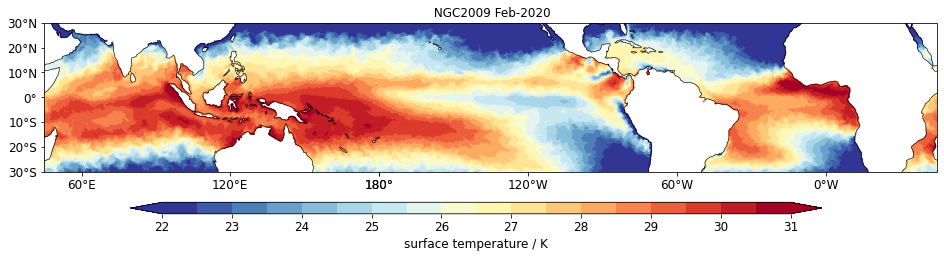

In [18]:
fig = plt.figure(figsize=(16, 8))
ax1=fig.add_axes([0.2,0.3,0.6,0.02])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter((ts1_mean01-273.15),int(10),ax,[-180,180],[-30,30],[22,31,18],\
                'RdYlBu_r','both',' NGC2009 Feb-2020',\
                'surface temperature / K',ax1,colorbar=True)

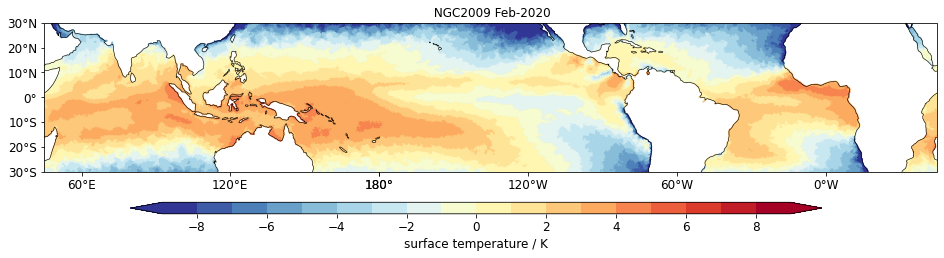

In [16]:
fig = plt.figure(figsize=(16, 8))
ax1=fig.add_axes([0.2,0.3,0.6,0.02])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter((ts1_mean01-ts1_mean01.mean()),int(10),ax,[-180,180],[-30,30],[-9,9,18],\
                'RdYlBu_r','both',' NGC2009 Feb-2020',\
                'surface temperature / K',ax1,colorbar=True)